In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import date

In [34]:
import matplotlib.pyplot as plt

In [38]:
from sklearn.metrics import mean_absolute_error

In [39]:
from sklearn.metrics import mean_squared_error

In [2]:
# Load Train Data
rawdata = pd.read_csv('../data/raw/train_aggr.csv',sep=';')

In [3]:
rawdata.head()

,id_pos,fecha_venta_norm,canal,unidades,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,...,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
0,3142,2012-12-01,ALMACEN,12,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,...,17.613333,1.333333,27.63,7.396667,0.260000,6.733333,0.72,0.210,3.793333,252050.3467
1,3142,2013-12-01,ALMACEN,7,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,...,17.613333,1.333333,27.63,7.396667,0.260000,6.733333,0.72,0.210,3.793333,252050.3467
2,3143,2013-11-01,ALMACEN,2,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,...,15.970000,0.936667,29.50,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067
3,3143,2013-12-01,ALMACEN,47,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,...,15.970000,0.936667,29.50,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067
4,3144,2012-11-01,ALMACEN,6,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,...,15.360000,1.841667,28.13,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233


In [4]:
rawdata.shape

(34540, 36)

In [5]:
rawdata['fecha_venta_norm'] = pd.to_datetime(rawdata['fecha_venta_norm'])

In [6]:
rawdata['fecha_venta_norm'] = rawdata['fecha_venta_norm'].dt.date

In [7]:
rawdata['year'] = pd.to_datetime(rawdata.fecha_venta_norm).dt.year
rawdata['month'] = pd.to_datetime(rawdata.fecha_venta_norm).dt.month

In [8]:
rawdata.fecha_venta_norm.unique()

array([datetime.date(2012, 12, 1), datetime.date(2013, 12, 1),
       datetime.date(2013, 11, 1), datetime.date(2012, 11, 1),
       datetime.date(2014, 11, 1), datetime.date(2014, 10, 1),
       datetime.date(2013, 10, 1), datetime.date(2013, 8, 1),
       datetime.date(2012, 10, 1), datetime.date(2014, 9, 1),
       datetime.date(2013, 9, 1), datetime.date(2013, 6, 1),
       datetime.date(2013, 7, 1)], dtype=object)

In [9]:
# Filtramos los meses que consideramos buenos para el entrenamiento (11 y 12)
rawdata = rawdata[rawdata.fecha_venta_norm.isin([date(2012, 11, 1),date(2012, 12, 1),
                                                date(2013, 11, 1), date(2013, 12, 1), date(2014, 11, 1)])]

In [10]:
rawdata.shape

(33960, 38)

In [11]:
rawdata.columns

Index(['id_pos', 'fecha_venta_norm', 'canal', 'unidades', 'competidores',
       'ingreso_mediana', 'ingreso_promedio', 'densidad_poblacional',
       'pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf', 'pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar', 'year', 'month'],
      dtype='object')

In [12]:
rawdata.sort_values(['id_pos','fecha_venta_norm'], ascending=True, inplace=True)

In [13]:
rawdata['unidades_target'] = rawdata.groupby(['id_pos'])['unidades'].shift(-1)

In [14]:
rawdata.head(10)

,id_pos,fecha_venta_norm,canal,unidades,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,...,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar,year,month,unidades_target
0,3142,2012-12-01,ALMACEN,12,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,...,7.396667,0.260000,6.733333,0.72,0.210,3.793333,252050.3467,2012,12,7.0
1,3142,2013-12-01,ALMACEN,7,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,...,7.396667,0.260000,6.733333,0.72,0.210,3.793333,252050.3467,2013,12,NaN
2,3143,2013-11-01,ALMACEN,2,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,...,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067,2013,11,47.0
3,3143,2013-12-01,ALMACEN,47,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,...,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067,2013,12,NaN
4,3144,2012-11-01,ALMACEN,6,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,...,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233,2012,11,41.0
5,3144,2012-12-01,ALMACEN,41,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,...,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233,2012,12,4.0
6,3144,2013-11-01,ALMACEN,4,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,...,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233,2013,11,71.0
7,3144,2013-12-01,ALMACEN,71,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,...,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233,2013,12,NaN
8,3146,2012-12-01,ALMACEN,7,5.0,24541.12000,38500.06000,9049.910000,5.310000,4.650000,...,3.880000,0.420000,0.410000,0.00,0.000,7.590000,112830.8300,2012,12,7.0
9,3146,2013-12-01,ALMACEN,7,5.0,24541.12000,38500.06000,9049.910000,5.310000,4.650000,...,3.880000,0.420000,0.410000,0.00,0.000,7.590000,112830.8300,2013,12,NaN


In [15]:
rawdata = rawdata[(rawdata.month == 11) & (rawdata.unidades_target.isnull()!=True)]

In [50]:
predictors = ['id_pos','unidades', 'unidades_target','canal', 'competidores',
       'ingreso_mediana', 'densidad_poblacional',
       'pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf', 'pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar']

In [51]:
X = rawdata[predictors].copy()

In [52]:
y = rawdata.unidades_target

In [53]:
X.drop('unidades_target', inplace=True, axis=1)

In [54]:
# fill Nans
for c in X.columns[X.dtypes != 'object']:
    X[c].fillna(X[c].median(), inplace=True)

In [55]:
# Label encoder
for c in X.columns[X.dtypes == 'object']:
    X[c] = X[c].factorize()[0]

In [56]:
X.head()

,id_pos,unidades,canal,competidores,ingreso_mediana,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,...,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
2,3143,2,0,33.0,55256.52333,67764.126670,6.316667,5.903333,6.0900,5.933333,...,15.9700,0.936667,29.5000,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067
4,3144,6,0,38.0,43437.32000,8799.223333,7.270000,7.240000,7.0550,6.766667,...,15.3600,1.841667,28.1300,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233
6,3144,4,0,38.0,43437.32000,8799.223333,7.270000,7.240000,7.0550,6.766667,...,15.3600,1.841667,28.1300,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233
10,3147,7,0,21.0,47007.34750,7390.012500,5.985000,6.585000,6.6725,6.762500,...,15.3225,0.807500,31.9725,5.087500,0.457500,0.397500,0.00,0.155,1.075000,128504.5700
12,3147,12,0,21.0,47007.34750,7390.012500,5.985000,6.585000,6.6725,6.762500,...,15.3225,0.807500,31.9725,5.087500,0.457500,0.397500,0.00,0.155,1.075000,128504.5700


#### Linear Regression

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
rf = RandomForestRegressor(max_depth=3, random_state=0,n_estimators=200,criterion='mae',n_jobs=-1)

In [59]:
model = rf.fit(X_train, y_train)


In [60]:
model.feature_importances_

array([8.50972176e-01, 1.43779042e-01, 3.20436725e-05, 9.47762648e-05,
       7.25683081e-05, 1.27212493e-04, 8.62049903e-05, 4.20225117e-04,
       9.52873322e-05, 0.00000000e+00, 2.53279457e-04, 7.79625904e-05,
       2.41360270e-04, 5.04441197e-05, 2.41955033e-04, 1.15997191e-04,
       2.80616228e-04, 1.43255091e-04, 3.11547384e-05, 7.48663175e-05,
       6.00573780e-05, 9.63908194e-05, 5.78383492e-04, 1.38640778e-04,
       2.09717735e-04, 8.20932400e-05, 2.71360759e-04, 2.32088829e-04,
       3.69332942e-05, 1.93033198e-04, 8.30770109e-05, 2.92003303e-04,
       4.54815045e-04, 8.09777618e-05])

Text(0, 0.5, 'Feature Importance Score')

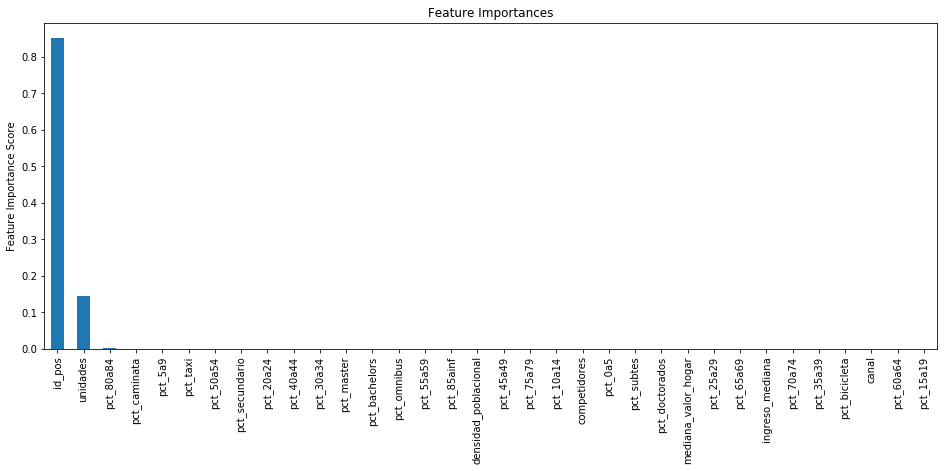

In [61]:

feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(16,6))
plt.ylabel('Feature Importance Score')

In [62]:
y_pred = model.predict(X_test)

In [63]:
mean_absolute_error(y_test, y_pred)

15.223111092660245

In [64]:
mean_squared_error(y_test, y_pred)

488.3279831555131

In [65]:
np.median(y_pred)

35.5825

### Train Final Model

In [103]:
model = LinearRegression(n_jobs=4).fit(X, y)

In [104]:
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)

print('slope:', model.coef_)

coefficient of determination: 0.0007475499909412875
intercept: -1.6365175382024901
slope: [ 8.70905905e-01 -1.12537594e-04 -1.09354694e-06 -3.07725037e-07
  3.28578227e-02  9.40190156e-03  3.46916655e-02  5.30874599e-02
  1.95930534e-02  4.02258919e-02  2.93068865e-02  2.66377692e-02
  2.53146258e-02  3.17748793e-02  4.45670177e-02  1.92741333e-02
  3.72199997e-02  6.98816004e-03  3.06150826e-02  6.65113521e-02
  4.60427094e-02  8.63861108e-03  2.67869965e-03 -1.20443590e-04
  3.58852659e-03  5.39232994e-03  2.14770958e-02 -1.63395871e-04
 -6.64356302e-04  1.01362499e-02 -4.33665929e-03  3.92879130e-08]


In [105]:
y_pred = model.predict(X)

In [106]:
mean_absolute_error(y, y_pred)

1.574054994556819